# baseline experiment

In [ ]:
!pip install -q -U diffusers transformers huggingface_hub accelerate sentencepiece

In [ ]:
from google.colab import drive
import os

drive.mount("/content/drive")

ROOT = "/content/drive/MyDrive/thesis2"

# reuse the same cache folder you used before (or create it)
HF_CACHE_DIR = f"{ROOT}/sd35_cache"
os.makedirs(HF_CACHE_DIR, exist_ok=True)

# Phase 1: smile experiment folders
PHASE_ROOT = f"{ROOT}/phase1_smile"
IMG_ROOT = f"{PHASE_ROOT}/images"
LOG_ROOT = f"{PHASE_ROOT}/logs"

os.makedirs(IMG_ROOT, exist_ok=True)
os.makedirs(LOG_ROOT, exist_ok=True)

os.environ["HF_HOME"] = HF_CACHE_DIR
os.environ["HF_HUB_CACHE"] = HF_CACHE_DIR

print("HF cache:", HF_CACHE_DIR)
print("Phase 1 images:", IMG_ROOT)
print("Phase 1 logs:", LOG_ROOT)


Mounted at /content/drive
HF cache: /content/drive/MyDrive/thesis2/sd35_cache
Phase 1 images: /content/drive/MyDrive/thesis2/phase1_smile/images
Phase 1 logs: /content/drive/MyDrive/thesis2/phase1_smile/logs


In [ ]:
!pip install -q -U diffusers transformers huggingface_hub accelerate sentencepiece

from huggingface_hub import login
from diffusers import StableDiffusion3Pipeline
import torch



model_id = "stabilityai/stable-diffusion-3.5-medium"

pipe = StableDiffusion3Pipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    token=HF_TOKEN,
)

pipe = pipe.to("cuda")
pipe.enable_attention_slicing()

print("Loaded on:", torch.cuda.get_device_name(0))


Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


model_index.json:   0%|          | 0.00/706 [00:00<?, ?B/s]

Fetching 26 files:   0%|          | 0/26 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/574 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/247M [00:00<?, ?B/s]

text_encoder_3/model-00002-of-00002.safe(…):   0%|          | 0.00/4.53G [00:00<?, ?B/s]

text_encoder_2/model.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

text_encoder_3/model-00001-of-00002.safe(…):   0%|          | 0.00/4.99G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/740 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/19.9k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/588 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/705 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/856 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/576 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

tokenizer_3/spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/20.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

transformer/diffusion_pytorch_model.safe(…):   0%|          | 0.00/4.94G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/524 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/809 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/168M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers
`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded on: NVIDIA L4


In [ ]:
# === Prompts for Phase 1: neutral / smile ===
BASE_FACE_PROMPT = (
    "a photorealistic portrait of a human face, studio lighting, "
    "high resolution, natural skin texture, realistic anatomy, "
    "professional photography, symmetric face, looking forward"
)

CONDITIONS = {
    "neutral": {
        "prompt": BASE_FACE_PROMPT
        + ", neutral expression, no smile, relaxed mouth, closed lips",
    },
    "smiling": {
        "prompt": BASE_FACE_PROMPT
        + ", smiling, visible teeth, joyful expression, warm smile",
    }
}


N_VARIANTS = 30       # images per condition
BASE_SEED = 123
HEIGHT = 768
WIDTH = 768
NUM_STEPS = 30
GUIDANCE_SCALE = 7.0


In [ ]:
import torch
import csv
from datetime import datetime

def get_condition_paths(condition_name: str):
    cond_img_dir = os.path.join(IMG_ROOT, condition_name)
    cond_log_path = os.path.join(LOG_ROOT, f"seed_diversity_{condition_name}.csv")
    os.makedirs(cond_img_dir, exist_ok=True)
    return cond_img_dir, cond_log_path

def generate_seed_diversity_for_condition(
    condition_name: str,
    n_variants: int = N_VARIANTS,
    base_seed: int = BASE_SEED,
    num_inference_steps: int = NUM_STEPS,
    guidance_scale: float = GUIDANCE_SCALE,
    height: int = HEIGHT,
    width: int = WIDTH,
):
    assert condition_name in CONDITIONS, f"Unknown condition: {condition_name}"
    prompt = CONDITIONS[condition_name]["prompt"]

    cond_img_dir, cond_log_path = get_condition_paths(condition_name)

    # init CSV if needed
    if not os.path.exists(cond_log_path):
        with open(cond_log_path, "w", newline="") as f:
            writer = csv.writer(f)
            writer.writerow([
                "timestamp",
                "condition",
                "prompt",
                "seed",
                "num_inference_steps",
                "guidance_scale",
                "height",
                "width",
                "image_path",
            ])

    for i in range(n_variants):
        seed = base_seed + i
        generator = torch.Generator(device="cuda").manual_seed(seed)

        print(f"[{condition_name}] {i+1}/{n_variants} (seed={seed})")
        image = pipe(
            prompt,
            num_inference_steps=num_inference_steps,
            guidance_scale=guidance_scale,
            height=height,
            width=width,
            generator=generator,
        ).images[0]

        fname = f"{condition_name}_seed{seed}.png"
        save_path = os.path.join(cond_img_dir, fname)
        image.save(save_path)

        with open(cond_log_path, "a", newline="") as f:
            writer = csv.writer(f)
            writer.writerow([
                datetime.now().isoformat(timespec="seconds"),
                condition_name,
                prompt,
                seed,
                num_inference_steps,
                guidance_scale,
                height,
                width,
                save_path,
            ])

        print("  saved:", save_path)

    print(f" Done for '{condition_name}'. Log at {cond_log_path}")


In [ ]:
generate_seed_diversity_for_condition("neutral")
generate_seed_diversity_for_condition("smiling")


[neutral] 1/30 (seed=123)


  0%|          | 0/30 [00:00<?, ?it/s]

  saved: /content/drive/MyDrive/thesis2/phase1_smile/images/neutral/neutral_seed123.png
[neutral] 2/30 (seed=124)


  0%|          | 0/30 [00:00<?, ?it/s]

  saved: /content/drive/MyDrive/thesis2/phase1_smile/images/neutral/neutral_seed124.png
[neutral] 3/30 (seed=125)


  0%|          | 0/30 [00:00<?, ?it/s]

  saved: /content/drive/MyDrive/thesis2/phase1_smile/images/neutral/neutral_seed125.png
[neutral] 4/30 (seed=126)


  0%|          | 0/30 [00:00<?, ?it/s]

  saved: /content/drive/MyDrive/thesis2/phase1_smile/images/neutral/neutral_seed126.png
[neutral] 5/30 (seed=127)


  0%|          | 0/30 [00:00<?, ?it/s]

  saved: /content/drive/MyDrive/thesis2/phase1_smile/images/neutral/neutral_seed127.png
[neutral] 6/30 (seed=128)


  0%|          | 0/30 [00:00<?, ?it/s]

  saved: /content/drive/MyDrive/thesis2/phase1_smile/images/neutral/neutral_seed128.png
[neutral] 7/30 (seed=129)


  0%|          | 0/30 [00:00<?, ?it/s]

  saved: /content/drive/MyDrive/thesis2/phase1_smile/images/neutral/neutral_seed129.png
[neutral] 8/30 (seed=130)


  0%|          | 0/30 [00:00<?, ?it/s]

  saved: /content/drive/MyDrive/thesis2/phase1_smile/images/neutral/neutral_seed130.png
[neutral] 9/30 (seed=131)


  0%|          | 0/30 [00:00<?, ?it/s]

  saved: /content/drive/MyDrive/thesis2/phase1_smile/images/neutral/neutral_seed131.png
[neutral] 10/30 (seed=132)


  0%|          | 0/30 [00:00<?, ?it/s]

  saved: /content/drive/MyDrive/thesis2/phase1_smile/images/neutral/neutral_seed132.png
[neutral] 11/30 (seed=133)


  0%|          | 0/30 [00:00<?, ?it/s]

  saved: /content/drive/MyDrive/thesis2/phase1_smile/images/neutral/neutral_seed133.png
[neutral] 12/30 (seed=134)


  0%|          | 0/30 [00:00<?, ?it/s]

  saved: /content/drive/MyDrive/thesis2/phase1_smile/images/neutral/neutral_seed134.png
[neutral] 13/30 (seed=135)


  0%|          | 0/30 [00:00<?, ?it/s]

  saved: /content/drive/MyDrive/thesis2/phase1_smile/images/neutral/neutral_seed135.png
[neutral] 14/30 (seed=136)


  0%|          | 0/30 [00:00<?, ?it/s]

  saved: /content/drive/MyDrive/thesis2/phase1_smile/images/neutral/neutral_seed136.png
[neutral] 15/30 (seed=137)


  0%|          | 0/30 [00:00<?, ?it/s]

  saved: /content/drive/MyDrive/thesis2/phase1_smile/images/neutral/neutral_seed137.png
[neutral] 16/30 (seed=138)


  0%|          | 0/30 [00:00<?, ?it/s]

  saved: /content/drive/MyDrive/thesis2/phase1_smile/images/neutral/neutral_seed138.png
[neutral] 17/30 (seed=139)


  0%|          | 0/30 [00:00<?, ?it/s]

  saved: /content/drive/MyDrive/thesis2/phase1_smile/images/neutral/neutral_seed139.png
[neutral] 18/30 (seed=140)


  0%|          | 0/30 [00:00<?, ?it/s]

  saved: /content/drive/MyDrive/thesis2/phase1_smile/images/neutral/neutral_seed140.png
[neutral] 19/30 (seed=141)


  0%|          | 0/30 [00:00<?, ?it/s]

  saved: /content/drive/MyDrive/thesis2/phase1_smile/images/neutral/neutral_seed141.png
[neutral] 20/30 (seed=142)


  0%|          | 0/30 [00:00<?, ?it/s]

  saved: /content/drive/MyDrive/thesis2/phase1_smile/images/neutral/neutral_seed142.png
[neutral] 21/30 (seed=143)


  0%|          | 0/30 [00:00<?, ?it/s]

  saved: /content/drive/MyDrive/thesis2/phase1_smile/images/neutral/neutral_seed143.png
[neutral] 22/30 (seed=144)


  0%|          | 0/30 [00:00<?, ?it/s]

  saved: /content/drive/MyDrive/thesis2/phase1_smile/images/neutral/neutral_seed144.png
[neutral] 23/30 (seed=145)


  0%|          | 0/30 [00:00<?, ?it/s]

  saved: /content/drive/MyDrive/thesis2/phase1_smile/images/neutral/neutral_seed145.png
[neutral] 24/30 (seed=146)


  0%|          | 0/30 [00:00<?, ?it/s]

  saved: /content/drive/MyDrive/thesis2/phase1_smile/images/neutral/neutral_seed146.png
[neutral] 25/30 (seed=147)


  0%|          | 0/30 [00:00<?, ?it/s]

  saved: /content/drive/MyDrive/thesis2/phase1_smile/images/neutral/neutral_seed147.png
[neutral] 26/30 (seed=148)


  0%|          | 0/30 [00:00<?, ?it/s]

  saved: /content/drive/MyDrive/thesis2/phase1_smile/images/neutral/neutral_seed148.png
[neutral] 27/30 (seed=149)


  0%|          | 0/30 [00:00<?, ?it/s]

  saved: /content/drive/MyDrive/thesis2/phase1_smile/images/neutral/neutral_seed149.png
[neutral] 28/30 (seed=150)


  0%|          | 0/30 [00:00<?, ?it/s]

  saved: /content/drive/MyDrive/thesis2/phase1_smile/images/neutral/neutral_seed150.png
[neutral] 29/30 (seed=151)


  0%|          | 0/30 [00:00<?, ?it/s]

  saved: /content/drive/MyDrive/thesis2/phase1_smile/images/neutral/neutral_seed151.png
[neutral] 30/30 (seed=152)


  0%|          | 0/30 [00:00<?, ?it/s]

  saved: /content/drive/MyDrive/thesis2/phase1_smile/images/neutral/neutral_seed152.png
✨ Done for 'neutral'. Log at /content/drive/MyDrive/thesis2/phase1_smile/logs/seed_diversity_neutral.csv
[smiling] 1/30 (seed=123)


  0%|          | 0/30 [00:00<?, ?it/s]

  saved: /content/drive/MyDrive/thesis2/phase1_smile/images/smiling/smiling_seed123.png
[smiling] 2/30 (seed=124)


  0%|          | 0/30 [00:00<?, ?it/s]

  saved: /content/drive/MyDrive/thesis2/phase1_smile/images/smiling/smiling_seed124.png
[smiling] 3/30 (seed=125)


  0%|          | 0/30 [00:00<?, ?it/s]

  saved: /content/drive/MyDrive/thesis2/phase1_smile/images/smiling/smiling_seed125.png
[smiling] 4/30 (seed=126)


  0%|          | 0/30 [00:00<?, ?it/s]

  saved: /content/drive/MyDrive/thesis2/phase1_smile/images/smiling/smiling_seed126.png
[smiling] 5/30 (seed=127)


  0%|          | 0/30 [00:00<?, ?it/s]

  saved: /content/drive/MyDrive/thesis2/phase1_smile/images/smiling/smiling_seed127.png
[smiling] 6/30 (seed=128)


  0%|          | 0/30 [00:00<?, ?it/s]

  saved: /content/drive/MyDrive/thesis2/phase1_smile/images/smiling/smiling_seed128.png
[smiling] 7/30 (seed=129)


  0%|          | 0/30 [00:00<?, ?it/s]

  saved: /content/drive/MyDrive/thesis2/phase1_smile/images/smiling/smiling_seed129.png
[smiling] 8/30 (seed=130)


  0%|          | 0/30 [00:00<?, ?it/s]

  saved: /content/drive/MyDrive/thesis2/phase1_smile/images/smiling/smiling_seed130.png
[smiling] 9/30 (seed=131)


  0%|          | 0/30 [00:00<?, ?it/s]

  saved: /content/drive/MyDrive/thesis2/phase1_smile/images/smiling/smiling_seed131.png
[smiling] 10/30 (seed=132)


  0%|          | 0/30 [00:00<?, ?it/s]

  saved: /content/drive/MyDrive/thesis2/phase1_smile/images/smiling/smiling_seed132.png
[smiling] 11/30 (seed=133)


  0%|          | 0/30 [00:00<?, ?it/s]

  saved: /content/drive/MyDrive/thesis2/phase1_smile/images/smiling/smiling_seed133.png
[smiling] 12/30 (seed=134)


  0%|          | 0/30 [00:00<?, ?it/s]

  saved: /content/drive/MyDrive/thesis2/phase1_smile/images/smiling/smiling_seed134.png
[smiling] 13/30 (seed=135)


  0%|          | 0/30 [00:00<?, ?it/s]

  saved: /content/drive/MyDrive/thesis2/phase1_smile/images/smiling/smiling_seed135.png
[smiling] 14/30 (seed=136)


  0%|          | 0/30 [00:00<?, ?it/s]

  saved: /content/drive/MyDrive/thesis2/phase1_smile/images/smiling/smiling_seed136.png
[smiling] 15/30 (seed=137)


  0%|          | 0/30 [00:00<?, ?it/s]

  saved: /content/drive/MyDrive/thesis2/phase1_smile/images/smiling/smiling_seed137.png
[smiling] 16/30 (seed=138)


  0%|          | 0/30 [00:00<?, ?it/s]

  saved: /content/drive/MyDrive/thesis2/phase1_smile/images/smiling/smiling_seed138.png
[smiling] 17/30 (seed=139)


  0%|          | 0/30 [00:00<?, ?it/s]

  saved: /content/drive/MyDrive/thesis2/phase1_smile/images/smiling/smiling_seed139.png
[smiling] 18/30 (seed=140)


  0%|          | 0/30 [00:00<?, ?it/s]

  saved: /content/drive/MyDrive/thesis2/phase1_smile/images/smiling/smiling_seed140.png
[smiling] 19/30 (seed=141)


  0%|          | 0/30 [00:00<?, ?it/s]

  saved: /content/drive/MyDrive/thesis2/phase1_smile/images/smiling/smiling_seed141.png
[smiling] 20/30 (seed=142)


  0%|          | 0/30 [00:00<?, ?it/s]

  saved: /content/drive/MyDrive/thesis2/phase1_smile/images/smiling/smiling_seed142.png
[smiling] 21/30 (seed=143)


  0%|          | 0/30 [00:00<?, ?it/s]

  saved: /content/drive/MyDrive/thesis2/phase1_smile/images/smiling/smiling_seed143.png
[smiling] 22/30 (seed=144)


  0%|          | 0/30 [00:00<?, ?it/s]

  saved: /content/drive/MyDrive/thesis2/phase1_smile/images/smiling/smiling_seed144.png
[smiling] 23/30 (seed=145)


  0%|          | 0/30 [00:00<?, ?it/s]

  saved: /content/drive/MyDrive/thesis2/phase1_smile/images/smiling/smiling_seed145.png
[smiling] 24/30 (seed=146)


  0%|          | 0/30 [00:00<?, ?it/s]

  saved: /content/drive/MyDrive/thesis2/phase1_smile/images/smiling/smiling_seed146.png
[smiling] 25/30 (seed=147)


  0%|          | 0/30 [00:00<?, ?it/s]

  saved: /content/drive/MyDrive/thesis2/phase1_smile/images/smiling/smiling_seed147.png
[smiling] 26/30 (seed=148)


  0%|          | 0/30 [00:00<?, ?it/s]

  saved: /content/drive/MyDrive/thesis2/phase1_smile/images/smiling/smiling_seed148.png
[smiling] 27/30 (seed=149)


  0%|          | 0/30 [00:00<?, ?it/s]

  saved: /content/drive/MyDrive/thesis2/phase1_smile/images/smiling/smiling_seed149.png
[smiling] 28/30 (seed=150)


  0%|          | 0/30 [00:00<?, ?it/s]

  saved: /content/drive/MyDrive/thesis2/phase1_smile/images/smiling/smiling_seed150.png
[smiling] 29/30 (seed=151)


  0%|          | 0/30 [00:00<?, ?it/s]

  saved: /content/drive/MyDrive/thesis2/phase1_smile/images/smiling/smiling_seed151.png
[smiling] 30/30 (seed=152)


  0%|          | 0/30 [00:00<?, ?it/s]

  saved: /content/drive/MyDrive/thesis2/phase1_smile/images/smiling/smiling_seed152.png
✨ Done for 'smiling'. Log at /content/drive/MyDrive/thesis2/phase1_smile/logs/seed_diversity_smiling.csv


In [ ]:
!pip install -q lpips scikit-image pandas matplotlib seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from PIL import Image
from skimage.metrics import structural_similarity as ssim
import lpips

device = "cuda" if torch.cuda.is_available() else "cpu"
lpips_model = lpips.LPIPS(net='vgg').to(device)
lpips_model.eval()

def load_image(path, size=None):
    img = Image.open(path).convert("RGB")
    if size is not None:
        img = img.resize(size, Image.BICUBIC)
    return img

def img_to_numpy(img):
    return np.asarray(img).astype(np.float32) / 255.0

def img_to_lpips_tensor(img):
    arr = np.asarray(img).astype(np.float32) / 255.0
    arr = (arr * 2.0) - 1.0
    arr = torch.from_numpy(arr).permute(2, 0, 1).unsqueeze(0)
    return arr.to(device)

def compute_pairwise_metrics_for_condition(condition_name: str):
    cond_img_dir, cond_log_path = get_condition_paths(condition_name)
    print(f"\n=== Metrics for: {condition_name} ===")
    print("Images:", cond_img_dir)
    print("Log:", cond_log_path)

    df = pd.read_csv(cond_log_path)
    df_cond = df[df["condition"] == condition_name].reset_index(drop=True)
    print("Rows:", len(df_cond))

    images_np, images_lpips, paths_used = [], [], []
    target_size = None

    for _, row in df_cond.iterrows():
        path = row["image_path"]
        if not os.path.exists(path):
            print("❌ missing:", path)
            continue

        if target_size is None:
            target_size = Image.open(path).convert("RGB").size

        img = load_image(path, size=target_size)
        images_np.append(img_to_numpy(img))
        images_lpips.append(img_to_lpips_tensor(img))
        paths_used.append(path)

    print("Loaded", len(images_np), "images of size", target_size)

    results = []
    n = len(images_np)

    for i in range(n):
        for j in range(i+1, n):
            seed_i = int(df_cond.loc[i, "seed"])
            seed_j = int(df_cond.loc[j, "seed"])

            arr_i, arr_j = images_np[i], images_np[j]

            mse_val = float(np.mean((arr_i - arr_j)**2))
            ssim_val = float(ssim(arr_i, arr_j, channel_axis=-1, data_range=1.0))
            with torch.no_grad():
                lpips_val = float(lpips_model(images_lpips[i], images_lpips[j]).item())

            results.append({
                "condition": condition_name,
                "seed_i": seed_i,
                "seed_j": seed_j,
                "image_i": paths_used[i],
                "image_j": paths_used[j],
                "MSE": mse_val,
                "SSIM": ssim_val,
                "LPIPS": lpips_val,
            })

            print(f"{condition_name} ({seed_i},{seed_j}) -> "
                  f"MSE={mse_val:.5f}, SSIM={ssim_val:.4f}, LPIPS={lpips_val:.4f}")

    metrics_df = pd.DataFrame(results)
    pairwise_path = os.path.join(LOG_ROOT, f"pairwise_{condition_name}.csv")
    metrics_df.to_csv(pairwise_path, index=False)
    print("saved pairwise to:", pairwise_path)

    # summary
    summary = {
        "condition": condition_name,
        "N_pairs": len(metrics_df),
        "LPIPS_mean": metrics_df["LPIPS"].mean(),
        "LPIPS_std":  metrics_df["LPIPS"].std(),
        "SSIM_mean":  metrics_df["SSIM"].mean(),
        "SSIM_std":   metrics_df["SSIM"].std(),
        "MSE_mean":   metrics_df["MSE"].mean(),
        "MSE_std":    metrics_df["MSE"].std(),
    }
    summary_df = pd.DataFrame([summary])
    display(summary_df)

    summary_path = os.path.join(LOG_ROOT, "seed_diversity_summary_smile.csv")
    if os.path.exists(summary_path):
        old = pd.read_csv(summary_path)
        pd.concat([old, summary_df], ignore_index=True).to_csv(summary_path, index=False)
    else:
        summary_df.to_csv(summary_path, index=False)

    print("updated summary at:", summary_path)
    return metrics_df, summary_df


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/vgg.pth


In [ ]:
metrics_neutral, summary_neutral = compute_pairwise_metrics_for_condition("neutral")
metrics_smiling, summary_smiling = compute_pairwise_metrics_for_condition("smiling")



=== Metrics for: neutral ===
Images: /content/drive/MyDrive/thesis2/phase1_smile/images/neutral
Log: /content/drive/MyDrive/thesis2/phase1_smile/logs/seed_diversity_neutral.csv
Rows: 30
Loaded 30 images of size (768, 768)
neutral (123,124) -> MSE=0.27195, SSIM=0.2771, LPIPS=0.6367
neutral (123,125) -> MSE=0.05616, SSIM=0.5882, LPIPS=0.5314
neutral (123,126) -> MSE=0.07435, SSIM=0.5760, LPIPS=0.5491
neutral (123,127) -> MSE=0.05058, SSIM=0.6276, LPIPS=0.4800
neutral (123,128) -> MSE=0.18978, SSIM=0.3819, LPIPS=0.5588
neutral (123,129) -> MSE=0.10636, SSIM=0.4910, LPIPS=0.5314
neutral (123,130) -> MSE=0.16747, SSIM=0.4281, LPIPS=0.5207
neutral (123,131) -> MSE=0.08434, SSIM=0.5711, LPIPS=0.4868
neutral (123,132) -> MSE=0.30429, SSIM=0.2875, LPIPS=0.6751
neutral (123,133) -> MSE=0.12519, SSIM=0.4520, LPIPS=0.4806
neutral (123,134) -> MSE=0.18423, SSIM=0.4169, LPIPS=0.5863
neutral (123,135) -> MSE=0.05947, SSIM=0.5707, LPIPS=0.4810
neutral (123,136) -> MSE=0.13482, SSIM=0.4549, LPIPS=0.63

condition  N_pairs  LPIPS_mean  LPIPS_std  SSIM_mean  SSIM_std  MSE_mean  \
0   neutral      435     0.58807   0.096682   0.465056  0.084278  0.138194   

    MSE_std  
0  0.060712

updated summary at: /content/drive/MyDrive/thesis2/phase1_smile/logs/seed_diversity_summary_smile.csv

=== Metrics for: smiling ===
Images: /content/drive/MyDrive/thesis2/phase1_smile/images/smiling
Log: /content/drive/MyDrive/thesis2/phase1_smile/logs/seed_diversity_smiling.csv
Rows: 30
Loaded 30 images of size (768, 768)
smiling (123,124) -> MSE=0.19489, SSIM=0.4212, LPIPS=0.4806
smiling (123,125) -> MSE=0.13044, SSIM=0.4772, LPIPS=0.6606
smiling (123,126) -> MSE=0.09559, SSIM=0.4889, LPIPS=0.4507
smiling (123,127) -> MSE=0.08284, SSIM=0.5090, LPIPS=0.5656
smiling (123,128) -> MSE=0.17007, SSIM=0.4510, LPIPS=0.7001
smiling (123,129) -> MSE=0.12775, SSIM=0.4593, LPIPS=0.5404
smiling (123,130) -> MSE=0.19444, SSIM=0.4126, LPIPS=0.5801
smiling (123,131) -> MSE=0.11594, SSIM=0.5058, LPIPS=0.6011
smiling (123,132) -> MSE=0.29120, SSIM=0.2809, LPIPS=0.7340
smiling (123,133) -> MSE=0.14495, SSIM=0.4940, LPIPS=0.4548
smiling (123,134) -> MSE=0.19279, SSIM=0.4170, LPIPS=0.5140
smiling (123,13

condition  N_pairs  LPIPS_mean  LPIPS_std  SSIM_mean  SSIM_std  MSE_mean  \
0   smiling      435    0.600721   0.097989   0.430474  0.079696  0.151001   

    MSE_std  
0  0.063945

updated summary at: /content/drive/MyDrive/thesis2/phase1_smile/logs/seed_diversity_summary_smile.csv


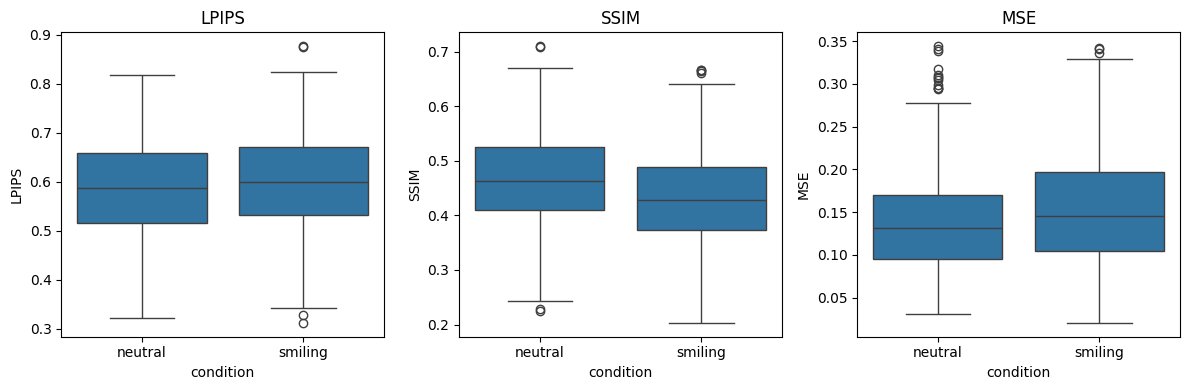

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

metrics_neutral["condition"] = "neutral"
metrics_smiling["condition"] = "smiling"
metrics_all = pd.concat([metrics_neutral, metrics_smiling], ignore_index=True)

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
sns.boxplot(data=metrics_all, x="condition", y="LPIPS")
plt.title("LPIPS")

plt.subplot(1,3,2)
sns.boxplot(data=metrics_all, x="condition", y="SSIM")
plt.title("SSIM")

plt.subplot(1,3,3)
sns.boxplot(data=metrics_all, x="condition", y="MSE")
plt.title("MSE")

plt.tight_layout()
plt.show()


# guidance

In [ ]:
import os

# Reuse ROOT from before if it exists, otherwise define it
try:
    ROOT
except NameError:
    ROOT = "/content/drive/MyDrive/thesis2"

P2_ROOT = f"{ROOT}/phase2_guidance_faces"
P2_RESULTS_ROOT = f"{P2_ROOT}/results/faces"
P2_LOG_ROOT = f"{P2_ROOT}/logs"

os.makedirs(P2_RESULTS_ROOT, exist_ok=True)
os.makedirs(P2_LOG_ROOT, exist_ok=True)

print("Phase 2 root:", P2_ROOT)
print("Results root:", P2_RESULTS_ROOT)
print("Logs root:", P2_LOG_ROOT)

# Prompts for Phase 2
P2_PROMPTS = {
    "neutral": (
          "a photorealistic portrait of a human face, studio lighting, "
          "high resolution, natural skin texture, realistic anatomy, "
          "professional photography, symmetric face, looking forward, "
          "neutral expression, no smile, relaxed mouth, closed lips"
),
    "smiling": (
        "a photorealistic portrait of a human face, studio lighting, "
        "high resolution, natural skin texture, realistic anatomy, "
        "professional photography, symmetric face, looking forward, "
        "smiling, visible teeth, joyful expression, warm smile"
    )
}

P2_GUIDANCE_LEVELS = [1.0, 3.0, 5.0, 7.5, 10.0]
P2_N_VARIANTS = 20
P2_BASE_SEED = 12345
P2_HEIGHT = 768
P2_WIDTH = 768
P2_NUM_STEPS = 18


Phase 2 root: /content/drive/MyDrive/thesis2/phase2_guidance_faces
Results root: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces
Logs root: /content/drive/MyDrive/thesis2/phase2_guidance_faces/logs


In [ ]:
import torch
import csv
from datetime import datetime

def p2_get_paths(condition: str, guidance: float):
    """Return (img_dir, log_path) for this condition + guidance."""
    g_str = str(guidance).replace('.', '_')
    img_dir = os.path.join(P2_RESULTS_ROOT, condition, f"guidance_{g_str}")
    os.makedirs(img_dir, exist_ok=True)

    # One log per condition across all guidance
    log_path = os.path.join(P2_LOG_ROOT, f"seed_diversity_{condition}_guidance.csv")
    return img_dir, log_path

def p2_generate_for_condition_guidance(
    condition: str,
    guidance: float,
    n_variants: int = P2_N_VARIANTS,
    base_seed: int = P2_BASE_SEED,
    num_inference_steps: int = P2_NUM_STEPS,
    height: int = P2_HEIGHT,
    width: int = P2_WIDTH,
):
    assert condition in P2_PROMPTS, f"Unknown condition: {condition}"
    prompt = P2_PROMPTS[condition]

    img_dir, log_path = p2_get_paths(condition, guidance)

    # Create CSV header if needed
    if not os.path.exists(log_path):
        with open(log_path, "w", newline="") as f:
            writer = csv.writer(f)
            writer.writerow([
                "timestamp",
                "condition",
                "prompt",
                "guidance_scale",
                "seed",
                "num_inference_steps",
                "height",
                "width",
                "image_path",
            ])

    for i in range(n_variants):
        seed = base_seed + i
        gen = torch.Generator(device="cuda").manual_seed(seed)

        print(f"[{condition}] guidance={guidance} | {i+1}/{n_variants} (seed={seed})")
        image = pipe(
            prompt,
            num_inference_steps=num_inference_steps,
            guidance_scale=guidance,
            height=height,
            width=width,
            generator=gen,
        ).images[0]

        g_str = str(guidance).replace('.', '_')
        fname = f"{condition}_g{g_str}_seed{seed}.png"
        save_path = os.path.join(img_dir, fname)
        image.save(save_path)

        with open(log_path, "a", newline="") as f:
            writer = csv.writer(f)
            writer.writerow([
                datetime.now().isoformat(timespec="seconds"),
                condition,
                prompt,
                guidance,
                seed,
                num_inference_steps,
                height,
                width,
                save_path,
            ])

        print("saved:", save_path)

    print(f"Done for condition={condition}, guidance={guidance}")


In [ ]:
for cond in ["neutral", "smiling"]:
    for g in P2_GUIDANCE_LEVELS:
        p2_generate_for_condition_guidance(cond, g)


[neutral] guidance=1.0 | 1/20 (seed=12345)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_1_0/neutral_g1_0_seed12345.png
[neutral] guidance=1.0 | 2/20 (seed=12346)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_1_0/neutral_g1_0_seed12346.png
[neutral] guidance=1.0 | 3/20 (seed=12347)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_1_0/neutral_g1_0_seed12347.png
[neutral] guidance=1.0 | 4/20 (seed=12348)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_1_0/neutral_g1_0_seed12348.png
[neutral] guidance=1.0 | 5/20 (seed=12349)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_1_0/neutral_g1_0_seed12349.png
[neutral] guidance=1.0 | 6/20 (seed=12350)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_1_0/neutral_g1_0_seed12350.png
[neutral] guidance=1.0 | 7/20 (seed=12351)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_1_0/neutral_g1_0_seed12351.png
[neutral] guidance=1.0 | 8/20 (seed=12352)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_1_0/neutral_g1_0_seed12352.png
[neutral] guidance=1.0 | 9/20 (seed=12353)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_1_0/neutral_g1_0_seed12353.png
[neutral] guidance=1.0 | 10/20 (seed=12354)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_1_0/neutral_g1_0_seed12354.png
[neutral] guidance=1.0 | 11/20 (seed=12355)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_1_0/neutral_g1_0_seed12355.png
[neutral] guidance=1.0 | 12/20 (seed=12356)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_1_0/neutral_g1_0_seed12356.png
[neutral] guidance=1.0 | 13/20 (seed=12357)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_1_0/neutral_g1_0_seed12357.png
[neutral] guidance=1.0 | 14/20 (seed=12358)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_1_0/neutral_g1_0_seed12358.png
[neutral] guidance=1.0 | 15/20 (seed=12359)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_1_0/neutral_g1_0_seed12359.png
[neutral] guidance=1.0 | 16/20 (seed=12360)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_1_0/neutral_g1_0_seed12360.png
[neutral] guidance=1.0 | 17/20 (seed=12361)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_1_0/neutral_g1_0_seed12361.png
[neutral] guidance=1.0 | 18/20 (seed=12362)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_1_0/neutral_g1_0_seed12362.png
[neutral] guidance=1.0 | 19/20 (seed=12363)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_1_0/neutral_g1_0_seed12363.png
[neutral] guidance=1.0 | 20/20 (seed=12364)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_1_0/neutral_g1_0_seed12364.png
Done for condition=neutral, guidance=1.0
[neutral] guidance=3.0 | 1/20 (seed=12345)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_3_0/neutral_g3_0_seed12345.png
[neutral] guidance=3.0 | 2/20 (seed=12346)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_3_0/neutral_g3_0_seed12346.png
[neutral] guidance=3.0 | 3/20 (seed=12347)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_3_0/neutral_g3_0_seed12347.png
[neutral] guidance=3.0 | 4/20 (seed=12348)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_3_0/neutral_g3_0_seed12348.png
[neutral] guidance=3.0 | 5/20 (seed=12349)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_3_0/neutral_g3_0_seed12349.png
[neutral] guidance=3.0 | 6/20 (seed=12350)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_3_0/neutral_g3_0_seed12350.png
[neutral] guidance=3.0 | 7/20 (seed=12351)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_3_0/neutral_g3_0_seed12351.png
[neutral] guidance=3.0 | 8/20 (seed=12352)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_3_0/neutral_g3_0_seed12352.png
[neutral] guidance=3.0 | 9/20 (seed=12353)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_3_0/neutral_g3_0_seed12353.png
[neutral] guidance=3.0 | 10/20 (seed=12354)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_3_0/neutral_g3_0_seed12354.png
[neutral] guidance=3.0 | 11/20 (seed=12355)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_3_0/neutral_g3_0_seed12355.png
[neutral] guidance=3.0 | 12/20 (seed=12356)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_3_0/neutral_g3_0_seed12356.png
[neutral] guidance=3.0 | 13/20 (seed=12357)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_3_0/neutral_g3_0_seed12357.png
[neutral] guidance=3.0 | 14/20 (seed=12358)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_3_0/neutral_g3_0_seed12358.png
[neutral] guidance=3.0 | 15/20 (seed=12359)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_3_0/neutral_g3_0_seed12359.png
[neutral] guidance=3.0 | 16/20 (seed=12360)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_3_0/neutral_g3_0_seed12360.png
[neutral] guidance=3.0 | 17/20 (seed=12361)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_3_0/neutral_g3_0_seed12361.png
[neutral] guidance=3.0 | 18/20 (seed=12362)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_3_0/neutral_g3_0_seed12362.png
[neutral] guidance=3.0 | 19/20 (seed=12363)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_3_0/neutral_g3_0_seed12363.png
[neutral] guidance=3.0 | 20/20 (seed=12364)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_3_0/neutral_g3_0_seed12364.png
Done for condition=neutral, guidance=3.0
[neutral] guidance=5.0 | 1/20 (seed=12345)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_5_0/neutral_g5_0_seed12345.png
[neutral] guidance=5.0 | 2/20 (seed=12346)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_5_0/neutral_g5_0_seed12346.png
[neutral] guidance=5.0 | 3/20 (seed=12347)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_5_0/neutral_g5_0_seed12347.png
[neutral] guidance=5.0 | 4/20 (seed=12348)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_5_0/neutral_g5_0_seed12348.png
[neutral] guidance=5.0 | 5/20 (seed=12349)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_5_0/neutral_g5_0_seed12349.png
[neutral] guidance=5.0 | 6/20 (seed=12350)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_5_0/neutral_g5_0_seed12350.png
[neutral] guidance=5.0 | 7/20 (seed=12351)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_5_0/neutral_g5_0_seed12351.png
[neutral] guidance=5.0 | 8/20 (seed=12352)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_5_0/neutral_g5_0_seed12352.png
[neutral] guidance=5.0 | 9/20 (seed=12353)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_5_0/neutral_g5_0_seed12353.png
[neutral] guidance=5.0 | 10/20 (seed=12354)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_5_0/neutral_g5_0_seed12354.png
[neutral] guidance=5.0 | 11/20 (seed=12355)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_5_0/neutral_g5_0_seed12355.png
[neutral] guidance=5.0 | 12/20 (seed=12356)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_5_0/neutral_g5_0_seed12356.png
[neutral] guidance=5.0 | 13/20 (seed=12357)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_5_0/neutral_g5_0_seed12357.png
[neutral] guidance=5.0 | 14/20 (seed=12358)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_5_0/neutral_g5_0_seed12358.png
[neutral] guidance=5.0 | 15/20 (seed=12359)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_5_0/neutral_g5_0_seed12359.png
[neutral] guidance=5.0 | 16/20 (seed=12360)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_5_0/neutral_g5_0_seed12360.png
[neutral] guidance=5.0 | 17/20 (seed=12361)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_5_0/neutral_g5_0_seed12361.png
[neutral] guidance=5.0 | 18/20 (seed=12362)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_5_0/neutral_g5_0_seed12362.png
[neutral] guidance=5.0 | 19/20 (seed=12363)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_5_0/neutral_g5_0_seed12363.png
[neutral] guidance=5.0 | 20/20 (seed=12364)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_5_0/neutral_g5_0_seed12364.png
Done for condition=neutral, guidance=5.0
[neutral] guidance=7.5 | 1/20 (seed=12345)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_7_5/neutral_g7_5_seed12345.png
[neutral] guidance=7.5 | 2/20 (seed=12346)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_7_5/neutral_g7_5_seed12346.png
[neutral] guidance=7.5 | 3/20 (seed=12347)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_7_5/neutral_g7_5_seed12347.png
[neutral] guidance=7.5 | 4/20 (seed=12348)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_7_5/neutral_g7_5_seed12348.png
[neutral] guidance=7.5 | 5/20 (seed=12349)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_7_5/neutral_g7_5_seed12349.png
[neutral] guidance=7.5 | 6/20 (seed=12350)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_7_5/neutral_g7_5_seed12350.png
[neutral] guidance=7.5 | 7/20 (seed=12351)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_7_5/neutral_g7_5_seed12351.png
[neutral] guidance=7.5 | 8/20 (seed=12352)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_7_5/neutral_g7_5_seed12352.png
[neutral] guidance=7.5 | 9/20 (seed=12353)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_7_5/neutral_g7_5_seed12353.png
[neutral] guidance=7.5 | 10/20 (seed=12354)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_7_5/neutral_g7_5_seed12354.png
[neutral] guidance=7.5 | 11/20 (seed=12355)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_7_5/neutral_g7_5_seed12355.png
[neutral] guidance=7.5 | 12/20 (seed=12356)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_7_5/neutral_g7_5_seed12356.png
[neutral] guidance=7.5 | 13/20 (seed=12357)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_7_5/neutral_g7_5_seed12357.png
[neutral] guidance=7.5 | 14/20 (seed=12358)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_7_5/neutral_g7_5_seed12358.png
[neutral] guidance=7.5 | 15/20 (seed=12359)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_7_5/neutral_g7_5_seed12359.png
[neutral] guidance=7.5 | 16/20 (seed=12360)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_7_5/neutral_g7_5_seed12360.png
[neutral] guidance=7.5 | 17/20 (seed=12361)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_7_5/neutral_g7_5_seed12361.png
[neutral] guidance=7.5 | 18/20 (seed=12362)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_7_5/neutral_g7_5_seed12362.png
[neutral] guidance=7.5 | 19/20 (seed=12363)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_7_5/neutral_g7_5_seed12363.png
[neutral] guidance=7.5 | 20/20 (seed=12364)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_7_5/neutral_g7_5_seed12364.png
Done for condition=neutral, guidance=7.5
[neutral] guidance=10.0 | 1/20 (seed=12345)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_10_0/neutral_g10_0_seed12345.png
[neutral] guidance=10.0 | 2/20 (seed=12346)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_10_0/neutral_g10_0_seed12346.png
[neutral] guidance=10.0 | 3/20 (seed=12347)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_10_0/neutral_g10_0_seed12347.png
[neutral] guidance=10.0 | 4/20 (seed=12348)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_10_0/neutral_g10_0_seed12348.png
[neutral] guidance=10.0 | 5/20 (seed=12349)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_10_0/neutral_g10_0_seed12349.png
[neutral] guidance=10.0 | 6/20 (seed=12350)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_10_0/neutral_g10_0_seed12350.png
[neutral] guidance=10.0 | 7/20 (seed=12351)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_10_0/neutral_g10_0_seed12351.png
[neutral] guidance=10.0 | 8/20 (seed=12352)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_10_0/neutral_g10_0_seed12352.png
[neutral] guidance=10.0 | 9/20 (seed=12353)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_10_0/neutral_g10_0_seed12353.png
[neutral] guidance=10.0 | 10/20 (seed=12354)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_10_0/neutral_g10_0_seed12354.png
[neutral] guidance=10.0 | 11/20 (seed=12355)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_10_0/neutral_g10_0_seed12355.png
[neutral] guidance=10.0 | 12/20 (seed=12356)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_10_0/neutral_g10_0_seed12356.png
[neutral] guidance=10.0 | 13/20 (seed=12357)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_10_0/neutral_g10_0_seed12357.png
[neutral] guidance=10.0 | 14/20 (seed=12358)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_10_0/neutral_g10_0_seed12358.png
[neutral] guidance=10.0 | 15/20 (seed=12359)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_10_0/neutral_g10_0_seed12359.png
[neutral] guidance=10.0 | 16/20 (seed=12360)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_10_0/neutral_g10_0_seed12360.png
[neutral] guidance=10.0 | 17/20 (seed=12361)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_10_0/neutral_g10_0_seed12361.png
[neutral] guidance=10.0 | 18/20 (seed=12362)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_10_0/neutral_g10_0_seed12362.png
[neutral] guidance=10.0 | 19/20 (seed=12363)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_10_0/neutral_g10_0_seed12363.png
[neutral] guidance=10.0 | 20/20 (seed=12364)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/neutral/guidance_10_0/neutral_g10_0_seed12364.png
Done for condition=neutral, guidance=10.0
[smiling] guidance=1.0 | 1/20 (seed=12345)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_1_0/smiling_g1_0_seed12345.png
[smiling] guidance=1.0 | 2/20 (seed=12346)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_1_0/smiling_g1_0_seed12346.png
[smiling] guidance=1.0 | 3/20 (seed=12347)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_1_0/smiling_g1_0_seed12347.png
[smiling] guidance=1.0 | 4/20 (seed=12348)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_1_0/smiling_g1_0_seed12348.png
[smiling] guidance=1.0 | 5/20 (seed=12349)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_1_0/smiling_g1_0_seed12349.png
[smiling] guidance=1.0 | 6/20 (seed=12350)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_1_0/smiling_g1_0_seed12350.png
[smiling] guidance=1.0 | 7/20 (seed=12351)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_1_0/smiling_g1_0_seed12351.png
[smiling] guidance=1.0 | 8/20 (seed=12352)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_1_0/smiling_g1_0_seed12352.png
[smiling] guidance=1.0 | 9/20 (seed=12353)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_1_0/smiling_g1_0_seed12353.png
[smiling] guidance=1.0 | 10/20 (seed=12354)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_1_0/smiling_g1_0_seed12354.png
[smiling] guidance=1.0 | 11/20 (seed=12355)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_1_0/smiling_g1_0_seed12355.png
[smiling] guidance=1.0 | 12/20 (seed=12356)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_1_0/smiling_g1_0_seed12356.png
[smiling] guidance=1.0 | 13/20 (seed=12357)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_1_0/smiling_g1_0_seed12357.png
[smiling] guidance=1.0 | 14/20 (seed=12358)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_1_0/smiling_g1_0_seed12358.png
[smiling] guidance=1.0 | 15/20 (seed=12359)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_1_0/smiling_g1_0_seed12359.png
[smiling] guidance=1.0 | 16/20 (seed=12360)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_1_0/smiling_g1_0_seed12360.png
[smiling] guidance=1.0 | 17/20 (seed=12361)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_1_0/smiling_g1_0_seed12361.png
[smiling] guidance=1.0 | 18/20 (seed=12362)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_1_0/smiling_g1_0_seed12362.png
[smiling] guidance=1.0 | 19/20 (seed=12363)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_1_0/smiling_g1_0_seed12363.png
[smiling] guidance=1.0 | 20/20 (seed=12364)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_1_0/smiling_g1_0_seed12364.png
Done for condition=smiling, guidance=1.0
[smiling] guidance=3.0 | 1/20 (seed=12345)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_3_0/smiling_g3_0_seed12345.png
[smiling] guidance=3.0 | 2/20 (seed=12346)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_3_0/smiling_g3_0_seed12346.png
[smiling] guidance=3.0 | 3/20 (seed=12347)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_3_0/smiling_g3_0_seed12347.png
[smiling] guidance=3.0 | 4/20 (seed=12348)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_3_0/smiling_g3_0_seed12348.png
[smiling] guidance=3.0 | 5/20 (seed=12349)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_3_0/smiling_g3_0_seed12349.png
[smiling] guidance=3.0 | 6/20 (seed=12350)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_3_0/smiling_g3_0_seed12350.png
[smiling] guidance=3.0 | 7/20 (seed=12351)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_3_0/smiling_g3_0_seed12351.png
[smiling] guidance=3.0 | 8/20 (seed=12352)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_3_0/smiling_g3_0_seed12352.png
[smiling] guidance=3.0 | 9/20 (seed=12353)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_3_0/smiling_g3_0_seed12353.png
[smiling] guidance=3.0 | 10/20 (seed=12354)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_3_0/smiling_g3_0_seed12354.png
[smiling] guidance=3.0 | 11/20 (seed=12355)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_3_0/smiling_g3_0_seed12355.png
[smiling] guidance=3.0 | 12/20 (seed=12356)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_3_0/smiling_g3_0_seed12356.png
[smiling] guidance=3.0 | 13/20 (seed=12357)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_3_0/smiling_g3_0_seed12357.png
[smiling] guidance=3.0 | 14/20 (seed=12358)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_3_0/smiling_g3_0_seed12358.png
[smiling] guidance=3.0 | 15/20 (seed=12359)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_3_0/smiling_g3_0_seed12359.png
[smiling] guidance=3.0 | 16/20 (seed=12360)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_3_0/smiling_g3_0_seed12360.png
[smiling] guidance=3.0 | 17/20 (seed=12361)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_3_0/smiling_g3_0_seed12361.png
[smiling] guidance=3.0 | 18/20 (seed=12362)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_3_0/smiling_g3_0_seed12362.png
[smiling] guidance=3.0 | 19/20 (seed=12363)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_3_0/smiling_g3_0_seed12363.png
[smiling] guidance=3.0 | 20/20 (seed=12364)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_3_0/smiling_g3_0_seed12364.png
Done for condition=smiling, guidance=3.0
[smiling] guidance=5.0 | 1/20 (seed=12345)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_5_0/smiling_g5_0_seed12345.png
[smiling] guidance=5.0 | 2/20 (seed=12346)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_5_0/smiling_g5_0_seed12346.png
[smiling] guidance=5.0 | 3/20 (seed=12347)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_5_0/smiling_g5_0_seed12347.png
[smiling] guidance=5.0 | 4/20 (seed=12348)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_5_0/smiling_g5_0_seed12348.png
[smiling] guidance=5.0 | 5/20 (seed=12349)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_5_0/smiling_g5_0_seed12349.png
[smiling] guidance=5.0 | 6/20 (seed=12350)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_5_0/smiling_g5_0_seed12350.png
[smiling] guidance=5.0 | 7/20 (seed=12351)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_5_0/smiling_g5_0_seed12351.png
[smiling] guidance=5.0 | 8/20 (seed=12352)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_5_0/smiling_g5_0_seed12352.png
[smiling] guidance=5.0 | 9/20 (seed=12353)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_5_0/smiling_g5_0_seed12353.png
[smiling] guidance=5.0 | 10/20 (seed=12354)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_5_0/smiling_g5_0_seed12354.png
[smiling] guidance=5.0 | 11/20 (seed=12355)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_5_0/smiling_g5_0_seed12355.png
[smiling] guidance=5.0 | 12/20 (seed=12356)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_5_0/smiling_g5_0_seed12356.png
[smiling] guidance=5.0 | 13/20 (seed=12357)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_5_0/smiling_g5_0_seed12357.png
[smiling] guidance=5.0 | 14/20 (seed=12358)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_5_0/smiling_g5_0_seed12358.png
[smiling] guidance=5.0 | 15/20 (seed=12359)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_5_0/smiling_g5_0_seed12359.png
[smiling] guidance=5.0 | 16/20 (seed=12360)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_5_0/smiling_g5_0_seed12360.png
[smiling] guidance=5.0 | 17/20 (seed=12361)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_5_0/smiling_g5_0_seed12361.png
[smiling] guidance=5.0 | 18/20 (seed=12362)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_5_0/smiling_g5_0_seed12362.png
[smiling] guidance=5.0 | 19/20 (seed=12363)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_5_0/smiling_g5_0_seed12363.png
[smiling] guidance=5.0 | 20/20 (seed=12364)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_5_0/smiling_g5_0_seed12364.png
Done for condition=smiling, guidance=5.0
[smiling] guidance=7.5 | 1/20 (seed=12345)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_7_5/smiling_g7_5_seed12345.png
[smiling] guidance=7.5 | 2/20 (seed=12346)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_7_5/smiling_g7_5_seed12346.png
[smiling] guidance=7.5 | 3/20 (seed=12347)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_7_5/smiling_g7_5_seed12347.png
[smiling] guidance=7.5 | 4/20 (seed=12348)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_7_5/smiling_g7_5_seed12348.png
[smiling] guidance=7.5 | 5/20 (seed=12349)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_7_5/smiling_g7_5_seed12349.png
[smiling] guidance=7.5 | 6/20 (seed=12350)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_7_5/smiling_g7_5_seed12350.png
[smiling] guidance=7.5 | 7/20 (seed=12351)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_7_5/smiling_g7_5_seed12351.png
[smiling] guidance=7.5 | 8/20 (seed=12352)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_7_5/smiling_g7_5_seed12352.png
[smiling] guidance=7.5 | 9/20 (seed=12353)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_7_5/smiling_g7_5_seed12353.png
[smiling] guidance=7.5 | 10/20 (seed=12354)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_7_5/smiling_g7_5_seed12354.png
[smiling] guidance=7.5 | 11/20 (seed=12355)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_7_5/smiling_g7_5_seed12355.png
[smiling] guidance=7.5 | 12/20 (seed=12356)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_7_5/smiling_g7_5_seed12356.png
[smiling] guidance=7.5 | 13/20 (seed=12357)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_7_5/smiling_g7_5_seed12357.png
[smiling] guidance=7.5 | 14/20 (seed=12358)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_7_5/smiling_g7_5_seed12358.png
[smiling] guidance=7.5 | 15/20 (seed=12359)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_7_5/smiling_g7_5_seed12359.png
[smiling] guidance=7.5 | 16/20 (seed=12360)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_7_5/smiling_g7_5_seed12360.png
[smiling] guidance=7.5 | 17/20 (seed=12361)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_7_5/smiling_g7_5_seed12361.png
[smiling] guidance=7.5 | 18/20 (seed=12362)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_7_5/smiling_g7_5_seed12362.png
[smiling] guidance=7.5 | 19/20 (seed=12363)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_7_5/smiling_g7_5_seed12363.png
[smiling] guidance=7.5 | 20/20 (seed=12364)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_7_5/smiling_g7_5_seed12364.png
Done for condition=smiling, guidance=7.5
[smiling] guidance=10.0 | 1/20 (seed=12345)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_10_0/smiling_g10_0_seed12345.png
[smiling] guidance=10.0 | 2/20 (seed=12346)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_10_0/smiling_g10_0_seed12346.png
[smiling] guidance=10.0 | 3/20 (seed=12347)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_10_0/smiling_g10_0_seed12347.png
[smiling] guidance=10.0 | 4/20 (seed=12348)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_10_0/smiling_g10_0_seed12348.png
[smiling] guidance=10.0 | 5/20 (seed=12349)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_10_0/smiling_g10_0_seed12349.png
[smiling] guidance=10.0 | 6/20 (seed=12350)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_10_0/smiling_g10_0_seed12350.png
[smiling] guidance=10.0 | 7/20 (seed=12351)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_10_0/smiling_g10_0_seed12351.png
[smiling] guidance=10.0 | 8/20 (seed=12352)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_10_0/smiling_g10_0_seed12352.png
[smiling] guidance=10.0 | 9/20 (seed=12353)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_10_0/smiling_g10_0_seed12353.png
[smiling] guidance=10.0 | 10/20 (seed=12354)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_10_0/smiling_g10_0_seed12354.png
[smiling] guidance=10.0 | 11/20 (seed=12355)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_10_0/smiling_g10_0_seed12355.png
[smiling] guidance=10.0 | 12/20 (seed=12356)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_10_0/smiling_g10_0_seed12356.png
[smiling] guidance=10.0 | 13/20 (seed=12357)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_10_0/smiling_g10_0_seed12357.png
[smiling] guidance=10.0 | 14/20 (seed=12358)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_10_0/smiling_g10_0_seed12358.png
[smiling] guidance=10.0 | 15/20 (seed=12359)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_10_0/smiling_g10_0_seed12359.png
[smiling] guidance=10.0 | 16/20 (seed=12360)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_10_0/smiling_g10_0_seed12360.png
[smiling] guidance=10.0 | 17/20 (seed=12361)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_10_0/smiling_g10_0_seed12361.png
[smiling] guidance=10.0 | 18/20 (seed=12362)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_10_0/smiling_g10_0_seed12362.png
[smiling] guidance=10.0 | 19/20 (seed=12363)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_10_0/smiling_g10_0_seed12363.png
[smiling] guidance=10.0 | 20/20 (seed=12364)


  0%|          | 0/18 [00:00<?, ?it/s]

saved: /content/drive/MyDrive/thesis2/phase2_guidance_faces/results/faces/smiling/guidance_10_0/smiling_g10_0_seed12364.png
Done for condition=smiling, guidance=10.0


In [ ]:
import numpy as np
import pandas as pd
from PIL import Image
from skimage.metrics import structural_similarity as ssim
import lpips

# Reuse lpips model if already defined, else init
try:
    lpips_model
except NameError:
    device = "cuda" if torch.cuda.is_available() else "cpu"
    lpips_model = lpips.LPIPS(net='vgg').to(device)
    lpips_model.eval()

device = "cuda" if torch.cuda.is_available() else "cpu"

def p2_load_image(path, size=None):
    img = Image.open(path).convert("RGB")
    if size is not None:
        img = img.resize(size, Image.BICUBIC)
    return img

def p2_img_to_numpy(img):
    return np.asarray(img).astype(np.float32) / 255.0

def p2_img_to_lpips_tensor(img):
    arr = np.asarray(img).astype(np.float32) / 255.0
    arr = (arr * 2.0) - 1.0
    arr = torch.from_numpy(arr).permute(2, 0, 1).unsqueeze(0)
    return arr.to(device)

def p2_compute_pairwise_for(condition: str, guidance: float):
    img_dir, log_path = p2_get_paths(condition, guidance)
    print(f"\n=== {condition} | guidance={guidance} ===")
    print("Log:", log_path)

    df = pd.read_csv(log_path)
    df_sub = df[(df["condition"] == condition) & (df["guidance_scale"] == guidance)].reset_index(drop=True)
    print("Rows:", len(df_sub))

    if len(df_sub) < 2:
        print("Not enough images for pairwise metrics.")
        return None, None

    images_np, images_lpips, paths_used = [], [], []
    target_size = None

    for _, row in df_sub.iterrows():
        path = row["image_path"]
        if not os.path.exists(path):
            print("missing:", path)
            continue

        if target_size is None:
            target_size = Image.open(path).convert("RGB").size

        img = p2_load_image(path, size=target_size)
        images_np.append(p2_img_to_numpy(img))
        images_lpips.append(p2_img_to_lpips_tensor(img))
        paths_used.append(path)

    print("Loaded", len(images_np), "images, size:", target_size)

    results = []
    n = len(images_np)

    for i in range(n):
        for j in range(i + 1, n):
            seed_i = int(df_sub.loc[i, "seed"])
            seed_j = int(df_sub.loc[j, "seed"])

            arr_i, arr_j = images_np[i], images_np[j]

            mse_val = float(np.mean((arr_i - arr_j) ** 2))
            ssim_val = float(ssim(arr_i, arr_j, channel_axis=-1, data_range=1.0))

            with torch.no_grad():
                lpips_val = float(lpips_model(images_lpips[i], images_lpips[j]).item())

            results.append({
                "condition": condition,
                "guidance_scale": guidance,
                "seed_i": seed_i,
                "seed_j": seed_j,
                "image_i": paths_used[i],
                "image_j": paths_used[j],
                "MSE": mse_val,
                "SSIM": ssim_val,
                "LPIPS": lpips_val,
            })

    metrics_df = pd.DataFrame(results)

    g_str = str(guidance).replace('.', '_')
    pairwise_name = f"seed_diversity_pairwise_{condition}_guidance_{g_str}.csv"
    pairwise_path = os.path.join(P2_LOG_ROOT, pairwise_name)
    metrics_df.to_csv(pairwise_path, index=False)
    print("✅ Saved pairwise metrics to:", pairwise_path)

    summary = {
        "condition": condition,
        "guidance_scale": guidance,
        "N_pairs": len(metrics_df),
        "LPIPS_mean": metrics_df["LPIPS"].mean(),
        "LPIPS_std":  metrics_df["LPIPS"].std(),
        "SSIM_mean":  metrics_df["SSIM"].mean(),
        "SSIM_std":   metrics_df["SSIM"].std(),
        "MSE_mean":   metrics_df["MSE"].mean(),
        "MSE_std":    metrics_df["MSE"].std(),
    }
    summary_df = pd.DataFrame([summary])
    display(summary_df)

    return metrics_df, summary_df


In [ ]:
def p2_run_all_metrics_for_condition(condition: str):
    all_summary = []
    for g in P2_GUIDANCE_LEVELS:
        metrics_df, summary_df = p2_compute_pairwise_for(condition, g)
        if summary_df is not None:
            all_summary.append(summary_df)

    if not all_summary:
        print("No metric summaries for", condition)
        return None

    summary_all = pd.concat(all_summary, ignore_index=True)
    summary_name = f"seed_diversity_summary_{condition}_guidance.csv"
    summary_path = os.path.join(P2_LOG_ROOT, summary_name)
    summary_all.to_csv(summary_path, index=False)
    print(f"\nSaved summary for {condition} to:", summary_path)
    display(summary_all)
    return summary_all

summary_neutral_p2 = p2_run_all_metrics_for_condition("neutral")
summary_smiling_p2 = p2_run_all_metrics_for_condition("smiling")



=== neutral | guidance=1.0 ===
Log: /content/drive/MyDrive/thesis2/phase2_guidance_faces/logs/seed_diversity_neutral_guidance.csv
Rows: 20
Loaded 20 images, size: (768, 768)
✅ Saved pairwise metrics to: /content/drive/MyDrive/thesis2/phase2_guidance_faces/logs/seed_diversity_pairwise_neutral_guidance_1_0.csv


condition  guidance_scale  N_pairs  LPIPS_mean  LPIPS_std  SSIM_mean  \
0   neutral             1.0      190    0.637908   0.095657   0.485333   

   SSIM_std  MSE_mean   MSE_std  
0  0.156481  0.077142  0.045654


=== neutral | guidance=3.0 ===
Log: /content/drive/MyDrive/thesis2/phase2_guidance_faces/logs/seed_diversity_neutral_guidance.csv
Rows: 20
Loaded 20 images, size: (768, 768)
✅ Saved pairwise metrics to: /content/drive/MyDrive/thesis2/phase2_guidance_faces/logs/seed_diversity_pairwise_neutral_guidance_3_0.csv


condition  guidance_scale  N_pairs  LPIPS_mean  LPIPS_std  SSIM_mean  \
0   neutral             3.0      190    0.513094   0.071794   0.552103   

   SSIM_std  MSE_mean   MSE_std  
0  0.077121   0.08772  0.043239


=== neutral | guidance=5.0 ===
Log: /content/drive/MyDrive/thesis2/phase2_guidance_faces/logs/seed_diversity_neutral_guidance.csv
Rows: 20
Loaded 20 images, size: (768, 768)
✅ Saved pairwise metrics to: /content/drive/MyDrive/thesis2/phase2_guidance_faces/logs/seed_diversity_pairwise_neutral_guidance_5_0.csv


condition  guidance_scale  N_pairs  LPIPS_mean  LPIPS_std  SSIM_mean  \
0   neutral             5.0      190    0.524795   0.071944   0.501439   

   SSIM_std  MSE_mean   MSE_std  
0  0.073186  0.113024  0.048782


=== neutral | guidance=7.5 ===
Log: /content/drive/MyDrive/thesis2/phase2_guidance_faces/logs/seed_diversity_neutral_guidance.csv
Rows: 20
Loaded 20 images, size: (768, 768)
✅ Saved pairwise metrics to: /content/drive/MyDrive/thesis2/phase2_guidance_faces/logs/seed_diversity_pairwise_neutral_guidance_7_5.csv


condition  guidance_scale  N_pairs  LPIPS_mean  LPIPS_std  SSIM_mean  \
0   neutral             7.5      190    0.554008   0.071781   0.441765   

   SSIM_std  MSE_mean   MSE_std  
0  0.085258  0.147262  0.065328


=== neutral | guidance=10.0 ===
Log: /content/drive/MyDrive/thesis2/phase2_guidance_faces/logs/seed_diversity_neutral_guidance.csv
Rows: 20
Loaded 20 images, size: (768, 768)
✅ Saved pairwise metrics to: /content/drive/MyDrive/thesis2/phase2_guidance_faces/logs/seed_diversity_pairwise_neutral_guidance_10_0.csv


condition  guidance_scale  N_pairs  LPIPS_mean  LPIPS_std  SSIM_mean  \
0   neutral            10.0      190    0.581191   0.085416   0.415209   

   SSIM_std  MSE_mean   MSE_std  
0  0.094657  0.163383  0.071613


✅ Saved summary for neutral to: /content/drive/MyDrive/thesis2/phase2_guidance_faces/logs/seed_diversity_summary_neutral_guidance.csv


condition  guidance_scale  N_pairs  LPIPS_mean  LPIPS_std  SSIM_mean  \
0   neutral             1.0      190    0.637908   0.095657   0.485333   
1   neutral             3.0      190    0.513094   0.071794   0.552103   
2   neutral             5.0      190    0.524795   0.071944   0.501439   
3   neutral             7.5      190    0.554008   0.071781   0.441765   
4   neutral            10.0      190    0.581191   0.085416   0.415209   

   SSIM_std  MSE_mean   MSE_std  
0  0.156481  0.077142  0.045654  
1  0.077121  0.087720  0.043239  
2  0.073186  0.113024  0.048782  
3  0.085258  0.147262  0.065328  
4  0.094657  0.163383  0.071613


=== smiling | guidance=1.0 ===
Log: /content/drive/MyDrive/thesis2/phase2_guidance_faces/logs/seed_diversity_smiling_guidance.csv
Rows: 20
Loaded 20 images, size: (768, 768)
✅ Saved pairwise metrics to: /content/drive/MyDrive/thesis2/phase2_guidance_faces/logs/seed_diversity_pairwise_smiling_guidance_1_0.csv


condition  guidance_scale  N_pairs  LPIPS_mean  LPIPS_std  SSIM_mean  \
0   smiling             1.0      190    0.652475   0.095565   0.469768   

   SSIM_std  MSE_mean   MSE_std  
0  0.156118  0.079693  0.046595


=== smiling | guidance=3.0 ===
Log: /content/drive/MyDrive/thesis2/phase2_guidance_faces/logs/seed_diversity_smiling_guidance.csv
Rows: 20
Loaded 20 images, size: (768, 768)
✅ Saved pairwise metrics to: /content/drive/MyDrive/thesis2/phase2_guidance_faces/logs/seed_diversity_pairwise_smiling_guidance_3_0.csv


condition  guidance_scale  N_pairs  LPIPS_mean  LPIPS_std  SSIM_mean  \
0   smiling             3.0      190    0.547208   0.063885   0.511657   

   SSIM_std  MSE_mean  MSE_std  
0  0.077412   0.09937   0.0479


=== smiling | guidance=5.0 ===
Log: /content/drive/MyDrive/thesis2/phase2_guidance_faces/logs/seed_diversity_smiling_guidance.csv
Rows: 20
Loaded 20 images, size: (768, 768)
✅ Saved pairwise metrics to: /content/drive/MyDrive/thesis2/phase2_guidance_faces/logs/seed_diversity_pairwise_smiling_guidance_5_0.csv


condition  guidance_scale  N_pairs  LPIPS_mean  LPIPS_std  SSIM_mean  \
0   smiling             5.0      190    0.553115     0.0638   0.459334   

   SSIM_std  MSE_mean   MSE_std  
0  0.076834  0.127356  0.054787


=== smiling | guidance=7.5 ===
Log: /content/drive/MyDrive/thesis2/phase2_guidance_faces/logs/seed_diversity_smiling_guidance.csv
Rows: 20
Loaded 20 images, size: (768, 768)
✅ Saved pairwise metrics to: /content/drive/MyDrive/thesis2/phase2_guidance_faces/logs/seed_diversity_pairwise_smiling_guidance_7_5.csv


condition  guidance_scale  N_pairs  LPIPS_mean  LPIPS_std  SSIM_mean  \
0   smiling             7.5      190    0.567258     0.0716   0.418573   

   SSIM_std  MSE_mean   MSE_std  
0  0.096941  0.144651  0.065812


=== smiling | guidance=10.0 ===
Log: /content/drive/MyDrive/thesis2/phase2_guidance_faces/logs/seed_diversity_smiling_guidance.csv
Rows: 20
Loaded 20 images, size: (768, 768)
✅ Saved pairwise metrics to: /content/drive/MyDrive/thesis2/phase2_guidance_faces/logs/seed_diversity_pairwise_smiling_guidance_10_0.csv


condition  guidance_scale  N_pairs  LPIPS_mean  LPIPS_std  SSIM_mean  \
0   smiling            10.0      190     0.57887   0.086916   0.419062   

   SSIM_std  MSE_mean   MSE_std  
0  0.103581  0.149945  0.066001


✅ Saved summary for smiling to: /content/drive/MyDrive/thesis2/phase2_guidance_faces/logs/seed_diversity_summary_smiling_guidance.csv


condition  guidance_scale  N_pairs  LPIPS_mean  LPIPS_std  SSIM_mean  \
0   smiling             1.0      190    0.652475   0.095565   0.469768   
1   smiling             3.0      190    0.547208   0.063885   0.511657   
2   smiling             5.0      190    0.553115   0.063800   0.459334   
3   smiling             7.5      190    0.567258   0.071600   0.418573   
4   smiling            10.0      190    0.578870   0.086916   0.419062   

   SSIM_std  MSE_mean   MSE_std  
0  0.156118  0.079693  0.046595  
1  0.077412  0.099370  0.047900  
2  0.076834  0.127356  0.054787  
3  0.096941  0.144651  0.065812  
4  0.103581  0.149945  0.066001

In [ ]:
def p2_metric_table(summary_df, metric: str, condition: str):
    tbl = summary_df[["guidance_scale", f"{metric}_mean"]].copy()
    tbl = tbl.sort_values("guidance_scale").reset_index(drop=True)
    tbl.columns = ["guidance_scale", f"{condition}_{metric}_mean"]
    return tbl

lpips_neutral_tbl = p2_metric_table(summary_neutral_p2, "LPIPS", "neutral")
lpips_smiling_tbl = p2_metric_table(summary_smiling_p2, "LPIPS", "smiling")

ssim_neutral_tbl = p2_metric_table(summary_neutral_p2, "SSIM", "neutral")
ssim_smiling_tbl = p2_metric_table(summary_smiling_p2, "SSIM", "smiling")

mse_neutral_tbl = p2_metric_table(summary_neutral_p2, "MSE", "neutral")
mse_smiling_tbl = p2_metric_table(summary_smiling_p2, "MSE", "smiling")

print("LPIPS vs guidance:")
display(lpips_neutral_tbl.merge(lpips_smiling_tbl, on="guidance_scale"))

print("SSIM vs guidance:")
display(ssim_neutral_tbl.merge(ssim_smiling_tbl, on="guidance_scale"))

print("MSE vs guidance:")
display(mse_neutral_tbl.merge(mse_smiling_tbl, on="guidance_scale"))


LPIPS vs guidance:


guidance_scale  neutral_LPIPS_mean  smiling_LPIPS_mean
0             1.0            0.637908            0.652475
1             3.0            0.513094            0.547208
2             5.0            0.524795            0.553115
3             7.5            0.554008            0.567258
4            10.0            0.581191            0.578870

SSIM vs guidance:


guidance_scale  neutral_SSIM_mean  smiling_SSIM_mean
0             1.0           0.485333           0.469768
1             3.0           0.552103           0.511657
2             5.0           0.501439           0.459334
3             7.5           0.441765           0.418573
4            10.0           0.415209           0.419062

MSE vs guidance:


guidance_scale  neutral_MSE_mean  smiling_MSE_mean
0             1.0          0.077142          0.079693
1             3.0          0.087720          0.099370
2             5.0          0.113024          0.127356
3             7.5          0.147262          0.144651
4            10.0          0.163383          0.149945

In [ ]:
import os
import re
import pandas as pd

# 🔁 1) Set this to your phase-2 logs folder
GUIDANCE_LOG_DIR = "/content/drive/MyDrive/thesis2/phase2_guidance_faces/logs"

# 🔁 2) Regex to catch condition + guidance value from filenames like:
#     seed_diversity_pairwise_neutral_guidance_1_0.csv
pairwise_pattern = re.compile(
    r"seed_diversity_pairwise_(neutral|smiling)_guidance_([0-9_]+)\.csv"
)

rows = []

for fname in os.listdir(GUIDANCE_LOG_DIR):
    m = pairwise_pattern.match(fname)
    if not m:
        continue

    condition = m.group(1)                 # "neutral" or "smiling"
    g_str = m.group(2)                     # e.g. "1_0", "7_5", "10_0"
    guidance = float(g_str.replace("_", "."))

    fpath = os.path.join(GUIDANCE_LOG_DIR, fname)
    df = pd.read_csv(fpath)

    # make column names easier to handle
    df.columns = [c.lower() for c in df.columns]

    # figure out which metrics are present
    metric_names = []
    for cand in ["lpips", "ssim", "mse", "clip_cosine_dst", "clip_dist"]:
        if cand in df.columns:
            metric_names.append(cand)

    stats = {"condition": condition, "guidance": guidance}

    for mname in metric_names:
        stats[f"{mname}_mean"] = df[mname].mean()
        stats[f"{mname}_std"] = df[mname].std()

    rows.append(stats)

# 3) Put everything in a DataFrame
guidance_summary = pd.DataFrame(rows)

# nice ordering
guidance_summary = guidance_summary.sort_values(
    by=["condition", "guidance"]
).reset_index(drop=True)

guidance_summary


condition  guidance  lpips_mean  lpips_std  ssim_mean  ssim_std  mse_mean  \
0   neutral       1.0    0.637908   0.095657   0.485333  0.156481  0.077142   
1   neutral       3.0    0.513094   0.071794   0.552103  0.077121  0.087720   
2   neutral       5.0    0.524795   0.071944   0.501439  0.073186  0.113024   
3   neutral       7.5    0.554008   0.071781   0.441765  0.085258  0.147262   
4   neutral      10.0    0.581191   0.085416   0.415209  0.094657  0.163383   
5   smiling       1.0    0.652475   0.095565   0.469768  0.156118  0.079693   
6   smiling       3.0    0.547208   0.063885   0.511657  0.077412  0.099370   
7   smiling       5.0    0.553115   0.063800   0.459334  0.076834  0.127356   
8   smiling       7.5    0.567258   0.071600   0.418573  0.096941  0.144651   
9   smiling      10.0    0.578870   0.086916   0.419062  0.103581  0.149945   

    mse_std  
0  0.045654  
1  0.043239  
2  0.048782  
3  0.065328  
4  0.071613  
5  0.046595  
6  0.047900  
7  0.054787  
8  0.065812  
9  0.066001

from matplotlib import pyplot as plt
guidance_summary['guidance'].plot(kind='hist', bins=20, title='guidance')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
guidance_summary['lpips_mean'].plot(kind='hist', bins=20, title='lpips_mean')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
guidance_summary['lpips_std'].plot(kind='hist', bins=20, title='lpips_std')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
guidance_summary['ssim_mean'].plot(kind='hist', bins=20, title='ssim_mean')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
guidance_summary.groupby('condition').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
guidance_summary.plot(kind='scatter', x='guidance', y='lpips_mean', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
guidance_summary.plot(kind='scatter', x='lpips_mean', y='lpips_std', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
guidance_summary.plot(kind='scatter', x='lpips_std', y='ssim_mean', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
guidance_summary.plot(kind='scatter', x='ssim_mean', y='ssim_std', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
guidance_summary['guidance'].plot(kind='line', figsize=(8, 4), title='guidance')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
guidance_summary['lpips_mean'].plot(kind='line', figsize=(8, 4), title='lpips_mean')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
guidance_summary['lpips_std'].plot(kind='line', figsize=(8, 4), title='lpips_std')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
guidance_summary['ssim_mean'].plot(kind='line', figsize=(8, 4), title='ssim_mean')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(guidance_summary['condition'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(guidance_summary, x='guidance', y='condition', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(guidance_summary['condition'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(guidance_summary, x='lpips_mean', y='condition', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(guidance_summary['condition'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(guidance_summary, x='lpips_std', y='condition', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(guidance_summary['condition'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(guidance_summary, x='ssim_mean', y='condition', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)